# **Hydrological modelling in Python**
> ## Practical using the STREAM model for the Colorado basin 

Notebook by Timothy Tiggeloven en Hans de Moel.   

![](./images/dynamic_images.gif)

# Hydrological Modelling

As mentioned during the lecture, there are many different water models around. In this practical you will work with a raster-based hydrological model to simulate river discharge of the Colorado river in the USA. This model, called STREAM, is programmed in Python and used in various studies performed at IVM. In this practical, STREAM will be runned using a monthly time step, meaning that the model makes a calculation for each month to estimate river discharge and other variables. There are questions throughout this practical which you have to answer in the accompanying excel file (see the separate sheet ‘Answers’). This practical will not be graded, but as you will work with STREAM yourself from tomorrow onwards, it is an important introduction.

![](./images/Hydrological_modelling.png)

# STREAM

STREAM is a distributed grid-based water-balance model and describes the hydrological cycle of a drainage basin as a series of storage compartments and flows. STREAM calculates per grid cell a water balance. The model consists of three storage reservoirs: snow storage, soil moisture storage and groundwater storage, dividing outflow into a fast and a slow component. The fast component is affected by soil moisture storage and the slow component by ground water storage, both behaving as linear reservoirs. Potential evapotranspiration is derived from surface temperature, following the approach of Thornthwaite and Mather (1957). Snow accumulation is equal to precipitation when temperature is below zero degrees Celsius, and snow melts linearly depending on temperature. Both fast and slow flows are routed to the basin outlet by flow accumulation using an elevation and assuming that all water moves through the system in one time step (in case of this practical: month). Because STREAM only needs precipitation and temperature as dynamic input variables, it is relatively simple and transparent to use. 

![](./images/STREAM_concept.png)

# **Part 1: Setting up the model**

Open the excel file named ‘CP1_HydroModel.xlsx’. In this excel file you will see several sheets. The first one ‘ClimateNumbering’ shows a table indicating which iteration number corresponds with which month (column) and year (row). Take a look at this sheet and look up the iteration number that corresponds to January 1910 and December 1914. This 5-year period will be used to calibrate the model. If you go to the next sheet ‘Calibration’, you’ll see observed discharge data (at Yuma, Arizona) for the period 1910-1914 in column C. There are also two graphs with show the discharge throughout these 5 years (top graph), and the average discharge per month (bottom graph). In column D there is place to paste the modelled data from the hydrological model STREAM (reddish cells). Other sheets in the excel file include ‘LongRuns’, ‘FullRuns’ and ‘Answers’. The ‘LongRuns’ and ‘FullRuns’ sheets we will use later when the model is calibrated and the ‘Answers’ tab gives questions that need answering over the course of this practical.        

## First things first
We are first going to import modules, prepare input files, and do some GIS-based operations in order to prepare our DEM for hydrological modelling.

## Modules and initialization

In order to use basic array operations, plot figures and run STREAM among others, we first need to specify which Python packages we are going to use in this practical. Note that the code *%matplotlib inline* is commented out (= made a comment/disabled) with a *'#'*. In case you encounter any problems in plotting figures, try uncommenting it by removing the <#>. You can ignore the ipython error.

In [2]:
# Modules and settings
import importlib
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import sys
import os
import warnings
import xarray as xr

from pysheds.grid import Grid

sys.path.append("..")
from models import STREAM_model as STREAM


# Hide warnings regarding nans in conditional statements
np.seterr(invalid='ignore')
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


## General statements

Next, we are specifying general statements about our discharge point in the raster, pixelsize and the number of seconds there are in a month (we are going to model discharge per second).

In [2]:
# Parameters
dischargepointrow = 228
dischargepointcolumn = 23
pixelsize = 5000
timestep = 24*3600*30

## Time selection

Select the corresponding start and end numbers for the time period 1910-1914. Check for this the *ClimateNumbering* sheet in the excel file. Make sure that *timestart* equals January of the first year. However, for the *timeend* you need to note down the number AFTER the last month of the last year (i.e. find the number of the January that comes after the December of the last year). The reason for this is because python counts up to, but not including,  that number. 

In [3]:
# Start and end time of iteration
timestart = 108       # Start month of simulation
timeend   = 168       # End month of simulation

Create list of months and years of the full extend of the data. Open *year_list* and *month_list* in the Variable Inspector (right-click to open) after running the next cell to check what is in these lists (i.e. what is calculated in the next cell).

In [4]:
# This is only for labels of future animation, not necessary for model [don't adjust]
start_year  = 1901
end_year    = 2009
start_month = 0     # 0 for January, 1 for February etc.
end_month   = 12    # 11 for November, 12 for December etc.

month_list, year_list = STREAM.set_dates(start_year, end_year, start_month, end_month)

## Input maps

STREAM uses various types of maps as input. Some of these maps are dynamic, meaning that every time step a new map is imported. This is the case for temperature and precipitation, for which unique maps exist for every month starting from January 1901 up to December 2009.
Other input maps are static, meaning they are imported once at the beginning, and don’t change during the calculations. These include maps related to the slope in the catchment (for groundwater flow), the land cover in the catchment (for evapotranspiration calculation), and the water holding capacity of the soil.   

Finally, there are some maps that are updated every time step. These are used for reservoirs for which the volume in the reservoir needs to be used in the next iteration. These include for instance snow, and water stored in the soil and groundwater reservoirs.   

Take a look at some of these input maps to get an idea of the catchment. Discharge will be simulated for the entire catchment up to the end of the river as shown in the figures (at the town of Yuma), which is where the Colorado river flows into Mexico. Notice the rather poor spatial resolution of the temperature data. The resolution of the precipitation data is similar. The resolution of climate data is often a constrain in hydrological modelling, especially for small catchments. Fortunately, the Colorado river basin is rather large.

![](./images/Input_maps.png)
![](./images/Landuse.png)

In [ ]:
# read land characteristic files
C = rasterio.open('..' + os.sep + 'models' + os.sep + 'Input_files' + os.sep + 'cmap.tif').read()[0]
Cropf  = rasterio.open('..' + os.sep + 'models' + os.sep + 'Input_files' + os.sep + 'cropf10.tif').read()[0]
Cropf  = Cropf / 10
Wholdn = rasterio.open('..' + os.sep + 'models' + os.sep + 'Input_files' + os.sep + 'wholdn.tif').read()[0]
Wholdn[Wholdn == -9999] = 5
Dem    = rasterio.open('..' + os.sep + 'models' + os.sep + 'Input_files' + os.sep + 'dem.tif').read()[0]

# read initial storage files
Aw   = np.ones_like(Dem)
Gw   = np.ones_like(Dem)
Snow = np.ones_like(Dem)

Temperature = np.load('..' + os.sep + 'models' + os.sep + 'Input_files' + os.sep + 'tmp.npy')
A = xr.open_dataset('..' + os.sep + 'models' + os.sep + 'Input_files' + os.sep + 'A.nc').to_array().values[0]
Precipitation = xr.open_dataset('..' + os.sep + 'models' + os.sep + 'Input_files' + os.sep + 'pre.nc').to_array().values[0]
Heat = xr.open_dataset('..' + os.sep + 'models' + os.sep + 'Input_files' + os.sep + 'Heat.nc').to_array().values[0]

## GIS-based operations

Next, we are going to prepare the DEM and transform the elevation height information into a flow direction map. The DEM may contain depressions or flats. If we don't remove those, the modelled water will dissapear instead of flowing to the point of outflow. We are going to use the Python package PySheds for these types of operations.

In [6]:
# load DEM into PySheds Grid
grid = Grid.from_raster('Input_files' + os.sep + 'dem.tif')
dem  = grid.read_raster('Input_files' + os.sep + 'dem.tif')

# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

## Setup STREAM

Now we are going to setup the model and pass all the relevant information to the model setup function. By doing this we create an object in Python and we call it *colorado*

In [7]:
importlib.reload(STREAM)

colorado = STREAM.Setup_model(dischargepointrow, dischargepointcolumn, pixelsize,
                              timestep, C, Cropf, Wholdn, Aw, Gw, Snow,
                              Precipitation, Temperature, Heat, A, grid, fdir, dirmap,
                              month_list, year_list)

# **Part 2: Calibrating the model**

Now we are going to model the discharge of water for the first time in the Colorado basin for the period 1910-1914.
We use the following variables in our model: \
*GW*     = Groundwater \
*Tmp*    = Temperature \
*Pe*     = Potential evapotranspiration \
*Pre*    = Precipitation \
*Excess* = Excess water, or surface runoff after evaporation and saturation of the soil \
*Aw*     = Available water (for plants) in the soil   \
*Runoff* = Runoff (both surface and subsurface) that leaves the grid cell. This is not accumulated/routed yet. \
*Qsec*   = routed or accumulated discharge in cubic meters per second. \

In [8]:
colorado.model_flow(timestart=timestart, timeend=timeend)

TimeseriesGw     = colorado.TimeseriesGw['Gw']
TimeseriesTmp    = colorado.TimeseriesTmp['Tmp']
TimeseriesPe     = colorado.TimeseriesPe['Pe']
TimeseriesPre    = colorado.TimeseriesPre['Pre']
TimeseriesExcess = colorado.TimeseriesExcess['Excess']
TimeseriesAw     = colorado.TimeseriesAw['Aw']
TimeseriesRunoff = colorado.TimeseriesRunoff['Runoff']
TimeseriesQsec   = colorado.TimeseriesQsec['Qsec']

100%|██████████| 60/60 [00:01<00:00, 58.69it/s]


When the model is finished, there is a lot of information stored as dataframes in the *colorado* object. Information in time series are stored for the following variables: Pre, Gw, Tmp, Pe, Excess, Aw, Runoff, Qsec. You can access these variable by typing the 'object name + . + TimeseriesVariable'. So for instance if we want to have information on groundwater, we can type: *colorado.TimeseriesGw*.    

At the general statements section we selected the location of the Yuma station with the row and column number. With the following plot you can hover over the image to find out where the station is located. ***Q1: Is the station located in the U.S. or Mexico? What discharge value do you find in this grid cell for this time-step?***

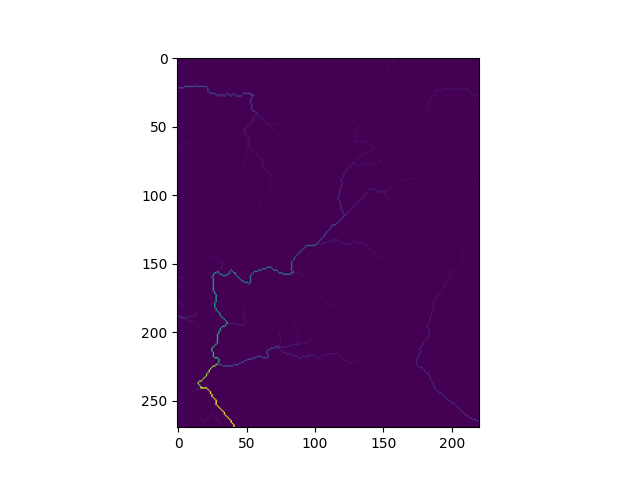

In [9]:
%matplotlib widget
colorado.locate_station(timestep=0)

You can plot the timeseries of the model with the following interactive plot. ***Q2: What patterns can you detect for each variable?***

In [10]:
%matplotlib inline
importlib.reload(STREAM)
colorado.plot_series()

BokehModel(combine_events=True, render_bundle={'docs_json': {'ade6c93f-e652-4729-b339-7ee41f7b5efc': {'version…

In [11]:
qstation = colorado.TimeseriesQsec

First, inspect the variable qstation in the Variable Inspector (right-click to open). After you have inspected the discharge values we are going to save this timeseries to Excel in order to compare it to the observed discharge. To save a dataframe to Excel, simply type qstation.to_excel(filename). Note that you need to change filename to a suitable name ending with the Excel extension xlsx.

In [12]:
qstation.to_excel('test.xlsx')

Copy the qstation data from the saved Excel file (download from the left, then open) and paste the data in your excel file in the reddish cells (in the Calibration tab). You will now see red curves in the graphs as well, resembling the model results for these 5 years.
***Q3: Compare the blue and red lines. Do you think they correspond well? Where seem to be the major differences?***


If you’ve compared the graphs, you’ll have noticed whilst the general picture seems to be there, there are some differences. We’ll now try and fix this by calibrating the model using several parameters. The main difference is that the first year seems to be completely off. We'll try to fix this by starting the simulation a year earlier (i.e. 1909), but disregarding the output of that first year. Subtract 12 (by adding -12) from the *timestart* and run the model again. Make sure to not include the first 12 numbers when copy pasting from the output excel! ***Q4: Compare the new results with the ones from the last run. Has the first year improved? What do you think is the reason behind this large difference?***

In [13]:
# Adjust Start time of iteration below
timestart = 108-12   # Start month of simulation
timeend   = 168      # End month of simulation

colorado.model_flow(timestart=timestart, timeend=timeend)
qstation = colorado.TimeseriesQsec
qstation.to_excel('warmingup.xlsx')

100%|██████████| 72/72 [00:01<00:00, 65.55it/s]


You should now see that the first year makes much more sense. However, you will also notice that the peak is a bit late. We can try to adjust this by changing melt factor. Adjust this by changing the *MELTcal* from 10 to 20 and running the model again. ***Q5: Compare the new results with the former ones. Did it improve? What do you think happened in the model?***

In [14]:
# Calibration parameters
colorado.HEATcal   = 1.0     # Not used in this practical: default=1 [>0]
colorado.WHOLDNcal = 1.5     # Water holding capacity of the soil: default=1 [>0]
colorado.MELTcal   = 20.0    # How fast snow melts: default=10 [>0]
colorado.CROPFcal  = 0.9     # Parameter steering the evapotranspiration: default=1 [>0]
colorado.TOGWcal   = 0.4     # Parameter seperating the fraction going to groundwater and direct runoff: default=0.4 [0-1]
colorado.Ccal      = 1.5     # Parameter steering how fast groundwater flows: default=1 [>1]

colorado.model_flow(timestart=timestart, timeend=timeend)
qstation = colorado.TimeseriesQsec
qstation.to_excel('testing.xlsx')

100%|██████████| 72/72 [00:01<00:00, 70.35it/s]


Whilst improved, we can still make the model better. You'll see that with increasing the meltfactor there now seems to be an overestimation of early-year discharge. We can try to adjust that by increasing the water-holding capacity (meaning the soil can store more water, leaving less for runoff). Adjust the *WHOLDNcal* to 1.5 and run it again to see if it improves. [use the same block of code above]

It's starting to look good now, but we can improve further. You'll see in the excell that the 'Difference' is lower than one, meaning we have less water annually in the model than there should be. We can adjust this by changing the crop factor that controls the evapotranspiration. Change this to 0.9 and see if the model improves. [again, you can use the block of code above] 

We're almost there. One last discrepancy you may spot is that the amplitude is slightly too large (with the low flow in autumn being too low). The amplitude of the hydrograph can be adjusted with teh C-factor. Change this to 1.5 and run the model again. Would you be happy with this final result? (if not you are free to tinker further with the parameters!)

# **Part 3: Running the calibrated model**

With the hydrological model calibrated, we can now do a long run and see how well it performs over a longer time. Look up the iteration numbers for January 1904 and December 1933 and run the model for this 30 year period. You can paste the results in the third tab in excel ‘LongRuns’ in column D and compare them with the observed discharge for that period.    
***Q6: Does the calibrated hydrological model perform well over the entire run?***


In [15]:
# change timestart and timeend
timestart = 36        # Start month of simulation
timeend   = 396       # End month of simulation
colorado.model_flow(timestart=timestart, timeend=timeend)
qstation = colorado.TimeseriesQsec
qstation.to_excel('long_run.xlsx')

100%|██████████| 360/360 [00:05<00:00, 67.13it/s]


Now that we have run the calibrated model for the entire timeseries, we can inspect the temporal and spatial patterns of the variables. To do so we can use the animate function of STREAM in order to display these patterns of discharge. Type colorado.animate() in the next cell.

In [16]:
# colorado.animate()

We can also animate spatial maps of other variables than discharge such as snow, snowmelt, evaporation, groundwater and soil water storage by passing the rasters argument into the animate function. This can be done by typing colorado.animate(rasters=colorado.var_name). Instead of var_name you can use the following variables: Gw_list, Aw_list, Snow_list, Melt_list, Pe_list and Qsec_list.

***Q7: What kind of spatial and temporal patterns can you detect in these variables? (Hint: Take a look at the landuse, soil classification, water holding and elevation maps displayed earlier)***

In [18]:
# colorado.animate(rasters=colorado.Gw_list)

# **Part 4: Model the effects of climate change**

Now you’ve set up a hydrological model for the Colorado river basin in the USA, we will do some experiments with the calibrated model to see how climate change may affect discharge. In addition, we’ll look at recent changes in the discharge of the Colorado river basin.   

Now we can use the calibrated model to see how climate change might possibly affect the availability of water resources in the Colorado catchment. Often this is done by loading in new precipitation and temperature maps generated by climate models. Here, however, we will take a simpler approach and just adjust temperature and precipitation manually, making this more a sensitivity analysis.    

We’ll start with precipitation. We can adjust precipitation. Go in the script of STREAM_model.py to line 94-97. Here the precipitation (PRE) and temperature (TMP) map are respectively imported. Add a new line in between where you add 10% precipitation. Then run the model again and paste the output in the excel file in column E (sheet LongRuns). In order to reload our modification of the STREAM, we also need to run the importlib.reload('Package Name') command (see below).   

***Q8: How would 10% extra precipitation affect the discharge (average, monthly) of the Colorado river? (Hint: make use of function .sum() or .mean() of the specific timeseries in the object colorado)***


In [21]:
importlib.reload(STREAM)
# add precipitation modification line in the STREAM model and calculate flow again
colorado = STREAM.Setup_model(dischargepointrow, dischargepointcolumn, pixelsize,
                              timestep, C, Cropf, Wholdn, Aw, Gw, Snow,
                              Precipitation, Temperature, Heat, A, grid, fdir, dirmap,
                              month_list, year_list)




timestart = 36        # Start month of simulation
timeend   = 396       # End month of simulation
colorado.model_flow(timestart=timestart, timeend=timeend)
qstation = colorado.TimeseriesQsec
qstation.to_excel('long_run.xlsx')

100%|██████████| 360/360 [00:05<00:00, 61.27it/s]


You may have noticed that the output did not change. When you make an adjustment in *stream_model.py*, you will also need to reset (1) the model and  (2) the *colorado* object. So search for the appropriate lines of code in earlier cells and paste them in correct order in the cell above. Then run it again (you should see some changes compared to the run without precipitation change). 

Now we’ll do temperature. Disable the line you just created for precipitation by putting a ‘#’ sign in front of it in order to comment out the line (you’ll see it will turn a different color). Then create a new line after importing of the TMP map, where you increase the temperature with 2 degrees. Run the model again and paste the results in column F (sheet LongRuns). Don't forget to add the code to reset the model and the *colorado* object!   

***Q9: How would an increase in temperature of 2 degrees affect the discharge (average, monthly) of the Colorado river?***


In [ ]:
importlib.reload(STREAM)
# add temperature modification line in the STREAM model and calculate flow again



Finally, we can take a look at the combined effect of increased precipitation and temperature. Enable the line where you increased the precipitation again by removing the ‘#’ sign and run the model again. Paste the results again in excel in column G (sheet LongRuns).   

***Q10: How would the combined effect of increased precipitation and temperature affect the discharge of the Colorado river?***

In [ ]:
importlib.reload(STREAM)
# add temperature and precipitation modification lines in the STREAM model and calculate flow again



# **Part 5: More recent discharge**

We’ve been calibrating and using the model now for the period 1904-1933, which was done on purpose.   

***Q11: Why do you think that we worked with a time period that is such a long time ago?***

We can have a look at the Colorado river discharge for the period 1904-1994 as well. Look up the iteration numbers, adjust them accordingly in the script and run the model. Make sure you’ve disabled the climate change effects and you use the calibrated values. Paste the result in the sheet ‘FullRuns’ (Column D). Then rightclick on the white table (which is a pivot table) and chose refresh to also calculate the modelled monthly discharges. You’ll notice that the averages don’t correspond at all. Make a (line) graph of the entire timeseries to search for the reason of this discrepancy.   

***Q12: Identify the reason for the big discrepancy in the averages.***   

***Q13: Look up from when it starts ‘going wrong’, what could have happened in reality? Search the internet to see if you can substantiate your idea.***

In [ ]:
# insert here code for Q12 and Q13, and analyze in excel



The difference in the modelled discharge and the observed discharge can be seen as a proxy of how much water is extracted and used in the basin. In column E you can calculate this by subtracting column C from column D. Do this from the moment that ‘things go wrong’. Take a look at these calculated differences. You’ll see that there are sometimes negative differences.   

***Q14: What does such a negative difference mean and how does that correspond with your rationale for the difference? (i.e. what happens in real life in such situation?)(hint: take a look during which months these negative differences occur)***

Clearly, a lot of water is consumed in the Colorado river basin. We can estimate this from our model by recalculating the difference in discharge per month (m3/sec) into a volume. We are going to do this for the last 6 years in our set (1989-1994) as we miss some data for 1988. The easiest thing to do is to first translate the m3/sec into m3/month. Do this in column F by multiplying the m3/sec with the amount of seconds that is in a month (assumed 30 days a month). Then we can recalculate the m3 into acre-feet, as that is the unit used in the USA for such numbers. One acre-foot corresponds to 1233.48 m3. Recalculate your m3 in column F to acre-feet in column G. Then use excel to calculate the average water use as modelled by our model per year.   

***Q15: What is your average modelled water use per year?***


The U.S. bureau of reclamation monitors water in the Colorado basin closely and frequently publishes all kinds of reports, including ones on the use and loss of water. Go to the following website: http://www.riversimulator.org/Resources/USBR/CULR/1991.pdf and download the report on consumptive uses and losses for the years 1991-1995 (which roughly corresponds with our period). There are a lot of numbers in the report, estimate the average water use and loss per year by calculating an average of the 5 years that are reported.   

***Q16: What is the reported average water use and loss per year? Does this correspond with your modelled estimate? (and make sure you understand why we can’t compare individual years)***

As you will notice, a rather large portion of the Colorado water resources are lost through evaporation from reservoirs.   

***Q17: What fraction of the total used water resources is roughly lost through evaporation from reservoirs? Which two reservoirs are most important in this respect?***